# Improving Expectation Values: Propagated Noise Absorption (PNA)

In this tutorial, we will learn how to leverage the latest tools in the Qiskit ecosystem to implement a fully customizable, error mitigated workflow. We will introduce the PNA technique and use it to mitigate gate errors. We will also use TREX to mitigate readout errors and post-selection to mitigate errors not captured in the learned noise model.

**Outline**
- Give a brief overview of ``PNA``
- Create a Trotterized quantum circuit and observable. Transpile it to the backend and include post-selection measurements.
- Use ``samplomatic`` to twirl layers of 2Q gates and measurements. Find unique 2Q layers to reduce noise learning cost.
- Use ``NoiseLearnerV3`` to learn the error model affecting the 2Q gates and measurements.
- Use ``qiskit-addon-pna`` to generate a noise-mitigating observable
- Use ``qiskit-ibm-runtime.Executor`` primitive to generate the raw QPU samples reflecting every shot for every twirling randomization and measured basis
- Use ``qiskit-addon-utils`` to post-process the data into a mitigated expectation value.

### What is propagated noise absorption (PNA)?

***A technique for mitigating gate errors by propagating the observable through the inverse noise channel affecting 2-qubit gates, resulting in a noise-mitigating observable.***

The 2Q gates in the experiment we want to run will be affected by substantial noise.

![Noisy experiment](images/noisy_expt.png)

If we learn the noise model, we can apply its inverse and cancel the noise.

![Noise-mitigated experiment](images/noise_mitigated_expt.png)

Instead of implementing the inverse noise channel by sampling it on the QPU as in PEC, we can implement it classically in the measured observable using Pauli propagation. This results in a more complex observable which, when measured, has the effect of mitigating the learned gate noise.

![PNA overview](images/pna_overview.png)

### Generate the mirrored Trotter circuit and observable

For this experiment, we will study the time dynamics of a 30-site kicked Ising model on a 1D spin chain. The Hamiltonian considered is:

$H = -J\sum\limits_{\langle i,j \rangle} Z_iZ_j + h\sum\limits_iX_i$,

where $J>0$ describes the coupling of nearest-neighbor spins, $i<j$, and the global transverse field, $h$, is set to $\frac{\pi}{8}$. The further $h$ is from a Clifford angle (i.e. $\theta=n\frac{\pi}{2}, n \in \mathbb{Z}$), the more difficult it becomes to propagate the anti-noise generators through the circuit.

For the choice of observable, we will consider the average single-site magnetization, $\frac{1}{N} \sum_{i=1}^{N} \langle z_i \rangle$, where $N$ is the number of sites.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp

num_qubits = 30
num_trotter_steps = 10
rx_angle = np.pi / 8

# Avg single-site magnetization
id_pauli = Pauli("I" * num_qubits)
observable = SparsePauliOp([id_pauli.dot(Pauli("Z"), [i]) for i in range(num_qubits)]) / num_qubits

In [2]:
def construct_ising_circuit(
    num_qubits: int, num_trotter_steps: int, rx_angle: float, barrier: bool = True
) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    for _step in range(num_trotter_steps):
        circuit.rx(rx_angle, range(num_qubits))
        if barrier:
            circuit.barrier()
        for first_qubit in (1, 2):
            for idx in range(first_qubit, num_qubits, 2):
                # equivalent to Rzz(-pi/2):
                circuit.sdg([idx - 1, idx])
                circuit.cz(idx - 1, idx)
        if barrier:
            circuit.barrier()

    return circuit


def prepare_basis(circuit: QuantumCircuit, basis: list[int]) -> QuantumCircuit:
    # basis is a list of integer values from 0 to 3. These map to the basis measurement as:
    # 0 = I; 1 = Z; 2 = X; 3 = Y
    assert len(basis) == circuit.num_qubits

    out_circ = circuit.copy_empty_like()
    for qb, bas in enumerate(basis):
        if bas in {0, 1}:
            continue
        if bas == 2:
            out_circ.h(qb)
        elif bas == 3:
            out_circ.rx(-np.pi / 2, qb)

    out_circ.barrier()
    out_circ.compose(circuit, inplace=True)
    return out_circ


def mirror_circuit(circuit: QuantumCircuit, *, inverse_first: bool = False) -> QuantumCircuit:
    mirror_circ = circuit.copy_empty_like()
    mirror_circ.compose(circuit.inverse() if inverse_first else circuit, inplace=True)
    mirror_circ.barrier()
    mirror_circ.compose(circuit if inverse_first else circuit.inverse(), inplace=True)
    mirror_circ.measure_active()
    return mirror_circ

In [3]:
circuit = construct_ising_circuit(num_qubits, num_trotter_steps, rx_angle, barrier=False)
circuit = mirror_circuit(circuit, inverse_first=True)

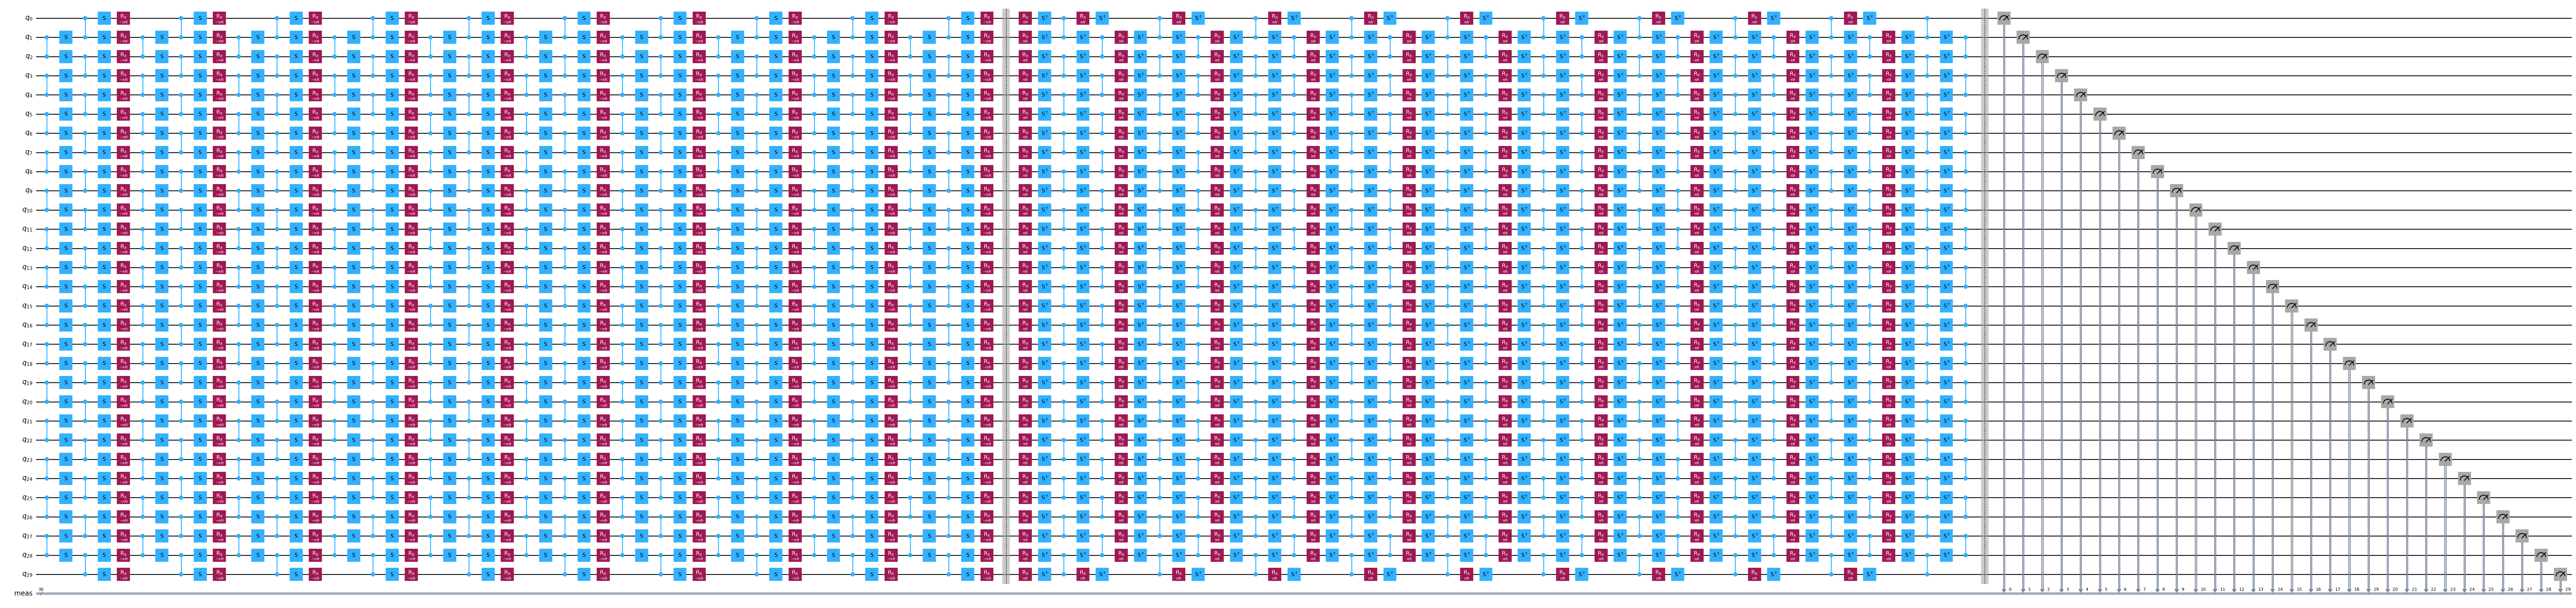

In [4]:
circuit.draw("mpl", fold=-1)

Next, we will choose a chain of qubits on ``ibm_kingston`` that report low error rates and transpile the circuit to the backend.

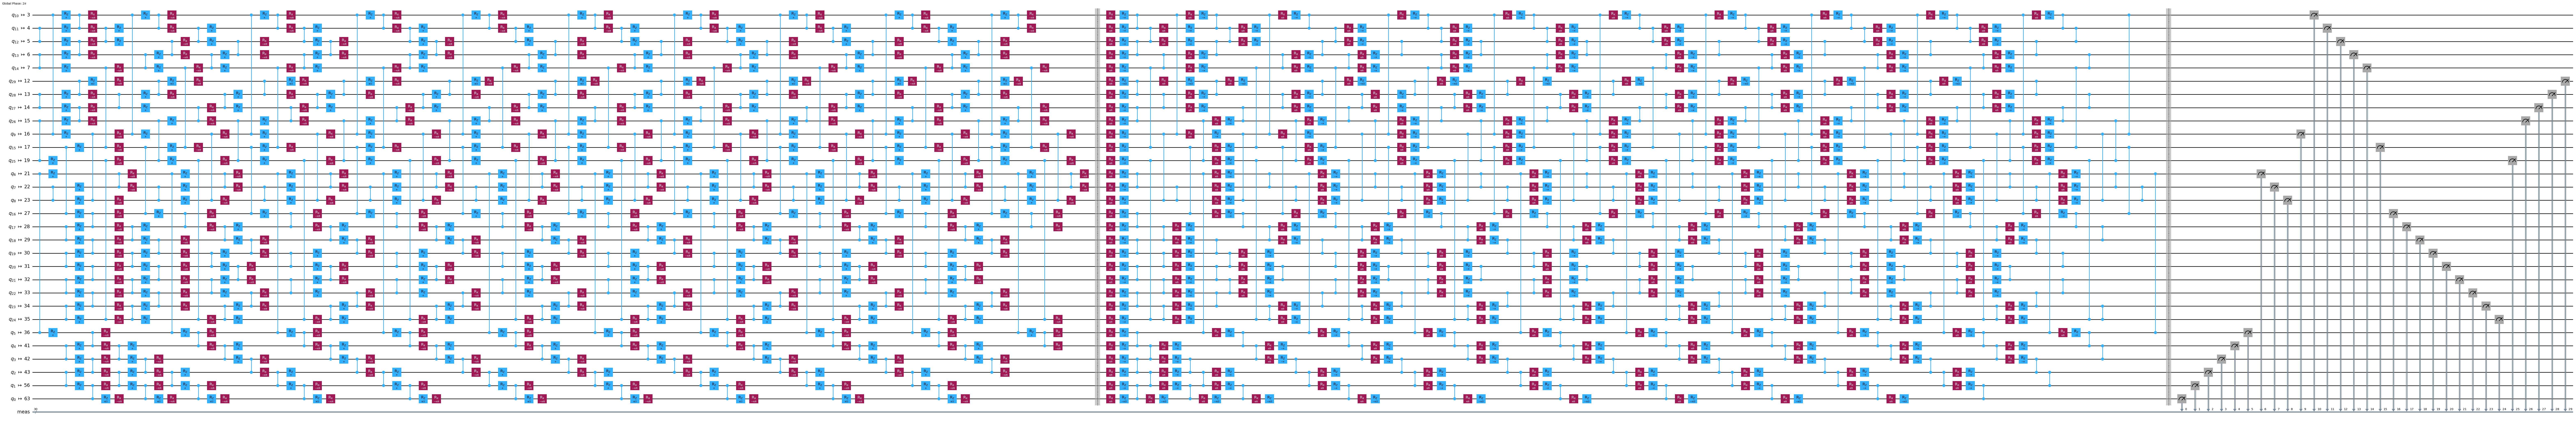

In [5]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import pickle

backend_name = "ibm_boston"
service = QiskitRuntimeService()
backend = service.backend(backend_name, use_fractional_gates=True)

# Use a chain of low-noise qubits
# layout = [
#     44,
#     45,
#     46,
#     47,
#     57,
#     67,
#     68,
#     69,
#     78,
#     89,
#     88,
#     87,
#     97,
#     107,
#     106,
#     105,
#     117,
#     125,
#     126,
#     127,
#     128,
#     129,
#     118,
#     109,
#     110,
#     111,
#     98,
#     91,
#     92,
#     93,
# ]

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(circuit)
layout = isa_circuit.layout.final_index_layout()
isa_observable = observable.apply_layout(isa_circuit.layout)
isa_circuit.draw("mpl", fold=-1)

### Twirl the 2-qubit gate layers and measurements and find unique layers

Here we ensure the pass manager annotates the boxes with ``Twirl`` and ``InjectNoise`` annotations, which allow us to learn the noise which will affect our circuit and associate that noise with its corresponding circuit layer.

- ``enable_gates/enable_measure: True``: Box all 2q gate layers and terminal measurements. Single qubit gates will be left-dressed within the boxes.
- ``measure_annotations: all`` Include `Twirl` and `ChangeBasis` annotations on the measurement box
- ``twirling_strategy: active``: Twirl all active qubits in each box containing entangling gates
- ``inject_noise_targets: gates``: ``InjectNoise`` annotations should be added to all ``Twirl``-annotated boxes containing entangling gates
- ``inject_noise_strategy: uniform_modification``: All of the noise layers should be scaled equivalently.

In [6]:
from samplomatic.transpiler import generate_boxing_pass_manager

# Box up circuit with Twirl and InjectNoise annotations
pm = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
    measure_annotations="all",
    twirling_strategy="active",
    inject_noise_targets="gates",
    inject_noise_strategy="uniform_modification",
    remove_barriers=True,
)
boxed_circuit = pm.run(isa_circuit)

/var/folders/fn/22865dwj63dc1q61xwfzrm5w0000gn/T/ipykernel_25852/1206180212.py:4: DeprecationWarning: Providing boolean values to the ``remove_barriers`` argument of ``generate_boxing_pass_manager()`` is deprecated as of samplomatic 0.14.0. It will be removed no earlier than 1 month after the release date. Instead, choose one of the string values.
  pm = generate_boxing_pass_manager(


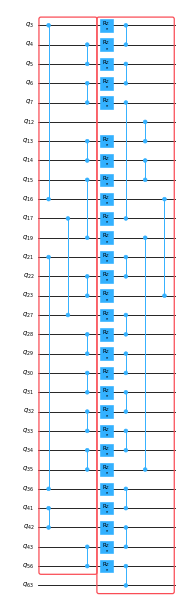

In [7]:
draw_circ = QuantumCircuit(boxed_circuit.num_qubits)
draw_circ.append(boxed_circuit.data[0], qargs=boxed_circuit.data[0].qubits)
draw_circ.append(boxed_circuit.data[1], qargs=boxed_circuit.data[1].qubits)
draw_circ.draw("mpl", fold=-1, scale=0.3, idle_wires=False)

### Generate the template circuit and samplex, define how the circuit will be sampled

Here we also add spectator and post-selection measurements, which are needed to perform post-selection on the samples output from ``Executor``.

In [8]:
import samplomatic
from qiskit.transpiler import PassManager
from qiskit_addon_utils.noise_management.post_selection.transpiler.passes import (
    AddPostSelectionMeasures,
    AddSpectatorMeasures,
)

# Build template circuit and samplex for later use with the "Executor"
template_circuit, samplex = samplomatic.build(boxed_circuit)

# Add post-selection instructions to the template circuit
post_selection_pm = PassManager(
    [
        AddSpectatorMeasures(backend.coupling_map),
        AddPostSelectionMeasures(x_pulse_type="rx"),
    ]
)
template_circuit = post_selection_pm.run(template_circuit)

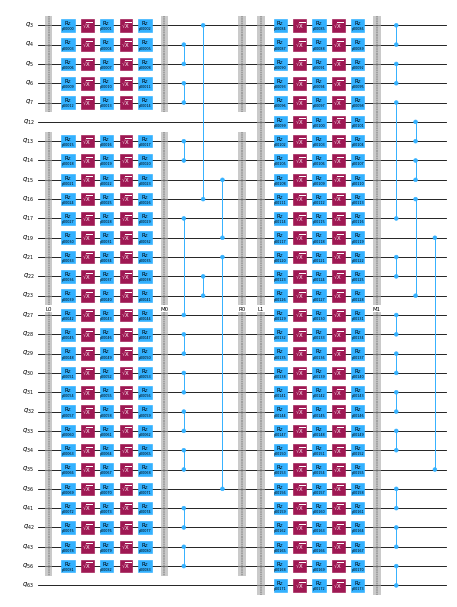

In [9]:
draw_circ = template_circuit.copy_empty_like()
draw_circ.data = template_circuit.data[:324]
draw_circ.draw("mpl", fold=-1, scale=0.3, idle_wires=False)

#### Learn the noise

Before we run the experiments, we learn the noise model affecting the entangling gates and measurements in the circuit. Having an accurate noise model is necessary to effectively mitigate error. Learning the noise just before executing the experiments gives the best chance of the noise model faithfully describing the actual noise affecting the gates during execution.

Before we learn the noise, we need to find the unique 2-qubit layers in our circuit, so we can minimize the number of shots needed to learn the noise for the entire circuit. We use ``find_unique_box_instructions`` from ``samplomatic`` to provide us the unique layers from the boxed circuit, including the measurement layer. These are the layers we pass to the noise learner.

Once we know the layers, we can learn the noise. There are a few parameters we consider:

- `num_randomizations`: The number of random circuits to use per learning circuit configuration
- `shots_per_randomization`: Total number of shots to use per random learning circuit
- `layer_pair_depths`: The circuit depths (measured in number of pairs) to use in learning experiments.
- `post_selection`: We will use edge-based post-selection during learning using `rx` gates to implement the post-measurement pulses

In [10]:
from qiskit_ibm_runtime.noise_learner_v3.noise_learner_v3 import NoiseLearnerV3
from qiskit_ibm_runtime.options import NoiseLearnerV3Options
from samplomatic.utils import find_unique_box_instructions

# Load noise learner data from a shared job
load_cached_noise_results = True

# Noise learning parameters
num_randomizations_nl = 64
shots_per_randomization_nl = 128
strategy = "edge"
enable_postsel = True
x_pulse_type = "rx"

# Find the unique instructions (layers) from boxed-up circuit
unique_2q_layers_and_meas = find_unique_box_instructions(
    boxed_circuit, normalize_annotations=None, undress_boxes=True
)

noise_learner_params = {
    "num_randomizations": num_randomizations_nl,
    "shots_per_randomization": shots_per_randomization_nl,
    "layer_pair_depths": [1, 2, 4, 8, 12, 16, 24, 32, 40, 48],
    "post_selection": {
        "enable": enable_postsel,
        "strategy": strategy,
        "x_pulse_type": x_pulse_type,
    },
    "experimental": {},
}
# set the options
noise_learner_options = NoiseLearnerV3Options(**noise_learner_params)

# run the noise learner job
noise_learner = NoiseLearnerV3(backend, noise_learner_options)

In [11]:
if load_cached_noise_results:
    with open("exp_data/PNA_noise_learner_results.pkl", "rb") as f:
        noise_learner_result = pickle.load(f)
else:
    noise_learner_job = noise_learner.run(unique_2q_instructions)
    noise_learner_result = noise_learner_job.result()

In [12]:
nl_metadata = noise_learner_params | {"layout": layout}

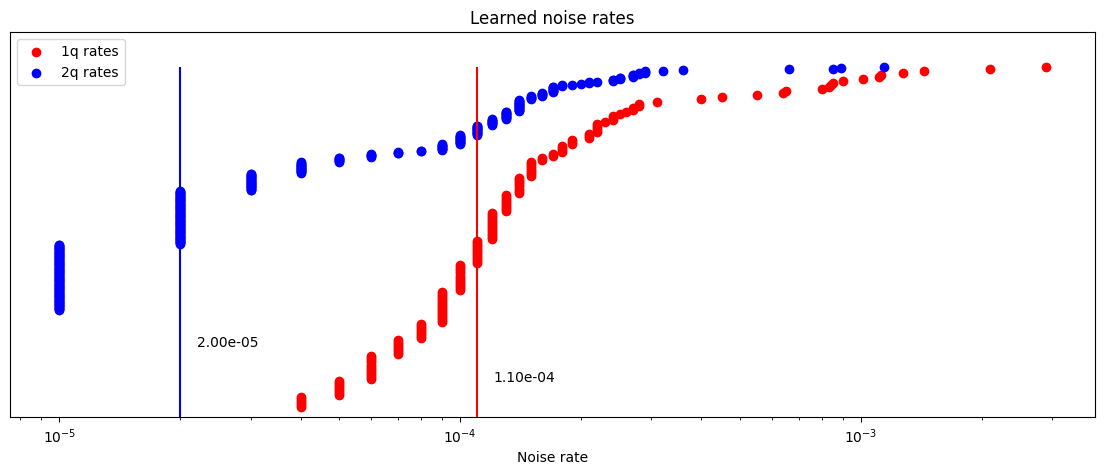

In [13]:
import matplotlib.pyplot as plt

hw_rates_1q = []
hw_rates_2q = []
for nlr in noise_learner_result[:2]:
    plm_list = nlr.to_pauli_lindblad_map().to_sparse_list()
    hw_rates_1q += [rate for (pstr, qubits, rate) in plm_list if len(pstr) == 1]
    hw_rates_2q += [rate for (pstr, qubits, rate) in plm_list if len(pstr) == 2]
hw_rates_1q = sorted(hw_rates_1q)
hw_rates_2q = sorted(hw_rates_2q)
median_1q = hw_rates_1q[len(hw_rates_1q) // 2]
median_2q = hw_rates_2q[len(hw_rates_2q) // 2]
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.scatter(
    (hw_rates_1q),
    [(i) / (len(hw_rates_1q) - 1) for i in range(len(hw_rates_1q))],
    color="red",
    label="1q rates",
)
ax.set_xscale("log")
ax.set_ylim(0, 1.1)
ax.vlines(median_1q, 0, 1, color="red")
ax.text(median_1q * 1.1, 0.1, f"{median_1q:.2e}")
ax.scatter(
    (hw_rates_2q),
    [(i) / (len(hw_rates_2q) - 1) for i in range(len(hw_rates_2q))],
    color="blue",
    label="2q rates",
)
ax.set_xscale("log")
ax.set_ylim(0, 1.1)
ax.vlines(median_2q, 0, 1, color="blue")
ax.text(median_2q * 1.1, 0.2, f"{median_2q:.2e}")
ax.set_title("Learned noise rates")
ax.set_xlabel("Noise rate")
ax.set_yticks([])
plt.legend()

#### Associate circuit boxes with learned noise

Here, we create a mapping between the ``InjectNoise`` reference IDs of each box to the learned noise model (`PauliLindbladMap`) affecting the entangling gates in that box.

In [14]:
from samplomatic.annotations import InjectNoise
from samplomatic.utils import get_annotation

# map inject noise refs to pauli lindblad maps
refs_to_noise_models = {}
for instruction, result in zip(unique_2q_layers_and_meas, noise_learner_result, strict=False):
    if inject_noise_annot := get_annotation(instruction.operation, InjectNoise):
        refs_to_noise_models[inject_noise_annot.ref] = result.to_pauli_lindblad_map()

#### Propagate the observable through the learned anti-noise to get a noise-mitigating observable

As discussed above, this is done in two steps. First, we propagate an anti-noise generator to the end of the circuit. After that, we propagate the observable through that evolved generator. This process is repeated for each anti-noise generator in the circuit. In this implementation, each generator in a given layer is propagated to the end of the circuit in parallel. Additionally, Python multiprocessing is used to perform both the forward-propagation of the anti-noise as well as the back-propagation of the observable in parallel. This prevents a pile-up of evolved generators in memory and also maximizes compute resources.

When running PNA, you will always need to provided a noisy circuit and observable. If your noisy circuit is a boxed circuit with `InjectNoise` annotations, you will need to provide the mapping we created in the step above. One can also pass a non-boxed circuit containing ``PauliLindbladError`` instructions from ``qiskit-aer``. In that case, ``refs_to_noise_models`` does not need to be provided. In addition to the primary inputs, users will want to consider:

- `max_err_terms`: The number of terms to keep in each anti-noise generator as it is forward-propagated. Allowing this to be larger generally increases accuracy, but this behavior is not guaranteed to be monotonic.
- `max_obs_terms`: The number of terms to keep in the noise-mitigating observable, $\tilde{O}$, as it is back-propagated through the evolved anti-noise. Larger values generally increase accuracy, but it is not guaranteed to do so monotonically.
- `num_processes`: The number of cores to dedicate to the process. Remember, the generators are forward-propagated and applied to the observable in parallel.
- `search_step`: The back-propagation step uses a greedy method to approximately conjugate two operators in the Pauli basis. This method can be sped up by increasing ``search_step``. See the [pauli-prop docs](https://qiskit.github.io/pauli-prop/) for more info.
- `num_to_measure`: While this variable isn't an input to ``generate_noise_mitigating_observable``, we use it to control how many terms from $\tilde{O}$ we actually want to measure. Here we will only measure the top 30 terms, which are the original terms in our observable. The terms have now been re-scaled such that measuring them has the effect of mitigating the learned gate noise. Although we only measure 30 terms from $\tilde{O}$, it is often still useful to allow it to grow large, as that increases the precision of the leading terms' scaling factors.

In [15]:
from qiskit_addon_pna import generate_noise_mitigating_observable

# PNA parameters
num_processes = 8
max_err_terms = 10_000
max_obs_terms = 10_000
num_to_measure = num_qubits

obs_tilde_isa = generate_noise_mitigating_observable(
    boxed_circuit,
    isa_observable,
    refs_to_noise_models,
    max_err_terms=max_err_terms,
    max_obs_terms=max_obs_terms,
    num_processes=num_processes,
    print_progress=True,
    search_step=8,
)
p_2_v = {p: v for v, p in enumerate(layout)}
obs_tilde_virtual = SparsePauliOp.from_sparse_list(
    [
        (pstr, [p_2_v[p] for p in p_qubits], coeff)
        for (pstr, p_qubits, coeff) in obs_tilde_isa.to_sparse_list()
    ],
    num_qubits=num_qubits,
)
obs_tilde_virtual = obs_tilde_virtual[np.argsort(np.abs(obs_tilde_virtual.coeffs))[::-1]][
    :num_to_measure
]

Finished! 13560 / 13560 generators propagated.                       

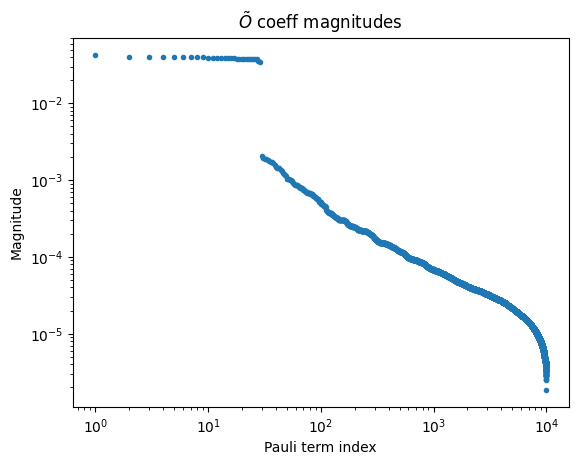

In [16]:
obs_tilde_isa = obs_tilde_isa[np.argsort(np.abs(obs_tilde_isa.coeffs))][::-1]
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\tilde{O}$ coeff magnitudes")
plt.ylabel("Magnitude")
plt.xlabel("Pauli term index")
plt.plot(np.abs(obs_tilde_isa.coeffs), ".")

#### Transform the measurement bases to canonical form

Next, we will find a minimal set of bases to measure such that we can fully cover every Pauli term in the measured observable (***many observables may be measured simultaneously if they commute qubit-wise***). Since we are only measuring the terms in our original observable, which is the sum of all single-`Z` Paulis, a single basis is needed -- the all-`Z` basis.

In addition to finding a set of Pauli measurement bases, we need to map these Pauli terms to the canonical form expected by the ``Executor`` primitive. For more information on canonical qubit ordering, visit the [samplomatic docs](https://qiskit.github.io/samplomatic/guides/samplex_io.html#qubit-ordering-convention).

In [17]:
from qiskit_addon_utils.exp_vals.measurement_bases import get_measurement_bases

meas_box = boxed_circuit.data[-1]
canonical_qubits = [
    idx for idx, qubit in enumerate(boxed_circuit.qubits) if qubit in meas_box.qubits
]
c_2_p = {c: p for c, p in enumerate(canonical_qubits)}  # canonical -> physical
p_2_v = {p: v for v, p in enumerate(layout)}  # physical -> virtual
c_2_v = {c: p_2_v[p] for c, p in c_2_p.items()}  # canonical -> virtual
meas_bases, bases_reverser = get_measurement_bases(obs_tilde_virtual)
meas_bases_canonical = [
    np.array([base[c_2_v[c]] for c in range(num_qubits)], dtype=np.uint8) for base in meas_bases
]

#### Specify how to sample in the ``QuantumProgram``

The ``QuantumProgram`` is where we specify how to sample the experiment:

- ``template_circuit``: The circuit containing all the gates necessary to implement all desired randomizations (from twirling randomizations, parameters, etc).
- ``samplex``: An object definining a probability distribution over all possible circuit randomizations from which to sample.
- ``samplex_arguments``: Bindings necessary to fully define the samplex
    - ``basis_changes``: Here is where we specify a set of bases to measure which will cover all of the Pauli terms in the measured observable.
    - ``noise_scales.ref``: We set each noise layer's scale to `0.0` to prevent any additional noise from being injected into our samples
    - ``pauli_lindblad_maps``: Required if ``noise_scales`` are passed. This just maps noise layers to the associated noise model.
- ``shape``: A shape tuple to extend the implicit shape defined by ``samplex_arguments``. Non-trivial axes introduced by this extension enumerate randomizations.

In [18]:
from qiskit_ibm_runtime import QuantumProgram

# Control the # of shots during execution
shots_per_randomization_exec = 64
num_randomizations_exec = 6144

# Zero out the noise to prevent noise from being injected during execution.
# We only added InjectNoise annotations so PNA could associate the noise
# to layers in the circuit
samplex_inputs = {f"noise_scales.{ref}": 0.0 for ref in refs_to_noise_models}
samplex_inputs |= {"pauli_lindblad_maps": refs_to_noise_models}

# Specify the bases to measure
bases_broadcastable = np.expand_dims(np.array(meas_bases_canonical), axis=1)
samplex_inputs |= {"basis_changes": {"basis0": bases_broadcastable}}

# Convert samplex_inputs into a dict to pass to QuantumProgram
samplex_arguments = samplex.inputs().make_broadcastable().bind(**samplex_inputs)

# Instantiate the QuantumProgram with the specified parameters
program = QuantumProgram(shots=shots_per_randomization_exec)
program.append(
    circuit=template_circuit,
    samplex=samplex,
    samplex_arguments=samplex_arguments,
    shape=(num_randomizations_exec),
)

#### Sample the circuit using the ``Executor`` primitive prototype

Now that we have defined our ``QuantumProgram``, executing the experiment is straightforward. We simply instantiate the ``Executor`` object, provide it the backend, and run the program.

In [19]:
from qiskit_ibm_runtime import Executor

# Execute (sample) the circuit
executor = Executor(backend)

In [20]:
load_cached_executor_results = True

In [21]:
if load_cached_executor_results:
    with open("exp_data/PNA_Exec_Results.pkl", "rb") as f:
        exec_results = pickle.load(f)
else:
    job_exec = executor.run(program)
    exec_results = job_exec.result()

#### Post-process the samples to calculate an error-mitigated expectation value

To calculate an error-mitigated expectation value, we will:

- Calculate the TREX scaling factors based on the learned noise affecting the measurements
- Generate a mask for keeping only post-selected samples
- Use the ``executor_expectation_values`` function from ``qiskit-addon-utils`` for combining all of the data into an error-mitigated expectation value.

In [22]:
from qiskit_addon_utils.exp_vals.expectation_values import executor_expectation_values
from qiskit_addon_utils.noise_management import trex_factors
from qiskit_addon_utils.noise_management.post_selection import PostSelector

# Computing the TREX factors
measurement_noise_map = noise_learner_result[2].to_pauli_lindblad_map()
trex_rescale_factors = trex_factors(measurement_noise_map, bases_reverser)

# Post-select the results
post_selector = PostSelector.from_circuit(
    circuit=template_circuit, coupling_map=backend.coupling_map
)

# Compute the ps mask for filtering results
mask = post_selector.compute_mask(exec_results[0], strategy="edge")

# Compute expvals using post selected results
results = executor_expectation_values(
    exec_results[0]["meas"],
    bases_reverser,
    meas_basis_axis=0,
    avg_axis=1,
    measurement_flips=exec_results[0]["measurement_flips.meas"],
    pauli_signs=exec_results[0].get("pauli_signs", None),
    postselect_mask=mask,
    rescale_factors=trex_rescale_factors,
)

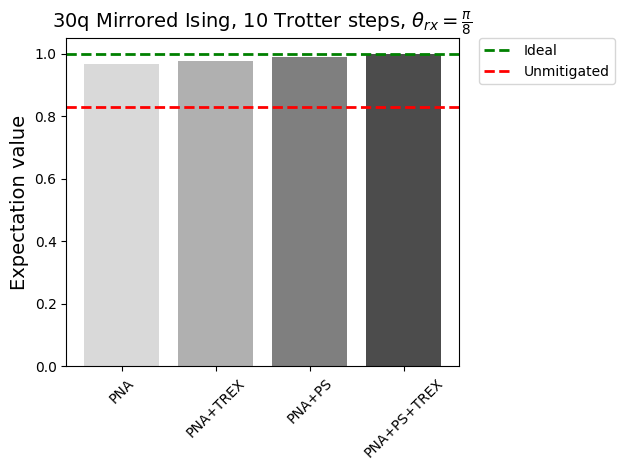

In [23]:
bases_reverser_unmit = {Pauli("Z" * num_qubits): [observable]}
args = [
    (bases_reverser_unmit, None, None),
    (bases_reverser, None, None),
    (bases_reverser, None, trex_rescale_factors),
    (bases_reverser, mask, None),
    (bases_reverser, mask, trex_rescale_factors),
]

evs = []
for reverser, postsel_mask, factors in args:
    # Compute expvals using post selected results
    res_ps = executor_expectation_values(
        exec_results[0]["meas"],
        reverser,
        meas_basis_axis=0,
        avg_axis=1,
        measurement_flips=exec_results[0]["measurement_flips.meas"],
        pauli_signs=exec_results[0].get("pauli_signs", None),
        postselect_mask=postsel_mask,
        rescale_factors=factors,
    )
    res_ps = np.array(res_ps)
    evs.append(res_ps[:, 0][0])

experiments = ["PNA", "PNA+TREX", "PNA+PS", "PNA+PS+TREX"]
colors = ["#d9d9d9", "#b0b0b0", "#7f7f7f", "#4c4c4c"]
plt.bar(experiments, evs[1:], color=colors)
plt.axhline(y=1, color="green", linestyle="--", linewidth=2, label="Ideal")
plt.axhline(y=evs[0], color="red", linestyle="--", linewidth=2, label="Unmitigated")
plt.ylabel("Expectation value", fontsize=14)

plt.title(r"30q Mirrored Ising, 10 Trotter steps, $\theta_{rx}=\frac{\pi}{8}$", fontsize=14)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()